In [1]:
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



# Download necessary NLTK packages
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
df = pd.read_csv("../PreProcessing/processed_data/Resume_proc_lemm.csv")

In [3]:
# Get a list of stop word
stop_words = set(nltk.corpus.stopwords.words('english'))

In [4]:
def preprocess(text):
    tokens = word_tokenize(text)
    return tokens

df['tokens'] = df['Resume_str'].apply(preprocess)

In [5]:
df.head()

,ID,Resume_str,Category,tokens
0,16852973,hr administrator marketing associate hr admini...,HR,"[hr, administrator, marketing, associate, hr, ..."
1,22323967,hr specialist u hr operation summary versatile...,HR,"[hr, specialist, u, hr, operation, summary, ve..."
2,33176873,hr director summary year experience recruiting...,HR,"[hr, director, summary, year, experience, recr..."
3,27018550,hr specialist summary dedicated driven dynamic...,HR,"[hr, specialist, summary, dedicated, driven, d..."
4,17812897,hr manager skill highlight hr skill hr departm...,HR,"[hr, manager, skill, highlight, hr, skill, hr,..."


In [6]:
# Training Word2Vec sul campo 'tokens'
tagged_data = [TaggedDocument(words=row['tokens'], tags=[str(idx)]) for idx, row in df.iterrows()]

In [7]:
d2v_model = Doc2Vec(vector_size=100, window=3, min_count=2, epochs=100)

In [8]:
d2v_model.build_vocab(tagged_data)
d2v_model.train(tagged_data, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

In [9]:
X = [d2v_model.infer_vector(row['tokens']) for idx, row in df.iterrows()]
y = df['Category']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [12]:
# Print the sizes of the split datasets
print("Train data size:", X_train.shape)
print("Validation data size:", X_test.shape)

Train data size: (1986, 100)
Validation data size: (497, 100)


In [13]:
def smote(X_train, y_train):
    #print("Distribuzione delle classi nel training set prima di SMOTE:")
    # print(y_train.value_counts())
    
    # Identifica le classi minoritarie
    class_counts = y_train.value_counts()
    min_classes = class_counts[class_counts < 0.7*class_counts.mean()].index.tolist()
    
    print(f"Applicazione di SMOTE alle classi: {min_classes} \n")
    
    # Crea un dizionario per la strategia di campionamento
    target_size = int(class_counts.max())
    sampling_strategy = {cls: target_size for cls in min_classes}
    
    # Applica SMOTE
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # print("Distribuzione delle classi nel training set dopo SMOTE:")
    # print(pd.Series(y_train_resampled).value_counts())
    
    return X_train_resampled, y_train_resampled

In [14]:
X_train_resampled, y_train_resampled = smote(X_train, y_train)

Applicazione di SMOTE alle classi: ['AGRICULTURE', 'AUTOMOBILE', 'BPO'] 



### Support Vector Classifier

In [15]:
# '''
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: f{results['mean_test_score'][candidate]:.3f} (std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}")
            print("")
# '''

In [16]:
skf = StratifiedKFold(n_splits=5)

In [17]:
# Pipeline: TF-IDF + Scaling + SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # with_mean=False per sparse matrix
    ('clf', SVC())
])

param_grid_svm = [
    {
        'clf__kernel': ['linear'],
        'clf__C': [0.1, 1, 10, 100]
    },
    {
        'clf__kernel': ['poly'],
        'clf__C': [1, 10],
        'clf__degree': [2, 3],
        'clf__coef0': [0.5, 1.0]
    }
]

grid_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid_svm,
    cv=skf,
    scoring='accuracy',
    verbose=3,
    n_jobs=-1
)


In [18]:
#'''
start = time()
grid_search_svm = grid_svm.fit(X_train_resampled, y_train_resampled)
print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search_svm.cv_results_['params'])} candidates parameter settings.\n")

report(grid_search_svm.cv_results_)
print(grid_search_svm.best_params_)
#'''

Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearchCV took 11.26 seconds for 12 candidates parameter settings.

Model with rank: 1
Mean validation score: f0.577 (std: 0.023)
Parameters: {'clf__C': 1, 'clf__coef0': 0.5, 'clf__degree': 3, 'clf__kernel': 'poly'}

Model with rank: 2
Mean validation score: f0.568 (std: 0.020)
Parameters: {'clf__C': 10, 'clf__coef0': 0.5, 'clf__degree': 3, 'clf__kernel': 'poly'}

Model with rank: 3
Mean validation score: f0.566 (std: 0.024)
Parameters: {'clf__C': 1, 'clf__coef0': 0.5, 'clf__degree': 2, 'clf__kernel': 'poly'}

Model with rank: 4
Mean validation score: f0.559 (std: 0.017)
Parameters: {'clf__C': 10, 'clf__coef0': 1.0, 'clf__degree': 3, 'clf__kernel': 'poly'}

Model with rank: 5
Mean validation score: f0.558 (std: 0.018)
Parameters: {'clf__C': 1, 'clf__coef0': 1.0, 'clf__degree': 3, 'clf__kernel': 'poly'}

Model with rank: 6
Mean validation score: f0.554 (std: 0.015)
Parameters: {'clf__C': 10, 'clf__coef0': 0.5, 'clf__degree'

In [19]:
print(grid_search_svm.best_params_)

{'clf__C': 1, 'clf__coef0': 0.5, 'clf__degree': 3, 'clf__kernel': 'poly'}


In [20]:
'''
# Estrai i risultati di GridSearchCV per SVM
results_svm = pd.DataFrame(grid_search_svm.cv_results_)

# Filtra i risultati in base ai parametri di interesse (ad esempio, kernel 'linear' vs 'rbf')
filtered_svm = results_svm[
    (results_svm['param_kernel'] == 'rbf')  # o 'linear' a seconda di cosa vuoi visualizzare
]

# Pivot table per visualizzare la "mean_test_score" in funzione di C e gamma
pvt_svm = filtered_svm.pivot_table(
    values='mean_test_score',
    index='param_C',
    columns='param_gamma'
)

# Crea la heatmap
f, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(pvt_svm, cmap='viridis', annot=True, ax=ax)
plt.title('SVM Accuracy (kernel=rbf)')
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

'''

'\n# Estrai i risultati di GridSearchCV per SVM\nresults_svm = pd.DataFrame(grid_search_svm.cv_results_)\n\n# Filtra i risultati in base ai parametri di interesse (ad esempio, kernel \'linear\' vs \'rbf\')\nfiltered_svm = results_svm[\n    (results_svm[\'param_kernel\'] == \'rbf\')  # o \'linear\' a seconda di cosa vuoi visualizzare\n]\n\n# Pivot table per visualizzare la "mean_test_score" in funzione di C e gamma\npvt_svm = filtered_svm.pivot_table(\n    values=\'mean_test_score\',\n    index=\'param_C\',\n    columns=\'param_gamma\'\n)\n\n# Crea la heatmap\nf, ax = plt.subplots(figsize=(6, 5))\nsns.heatmap(pvt_svm, cmap=\'viridis\', annot=True, ax=ax)\nplt.title(\'SVM Accuracy (kernel=rbf)\')\nplt.xlabel(\'gamma\')\nplt.ylabel(\'C\')\nplt.show()\n\n'

In [21]:
SVC_Model_best = grid_search_svm.best_estimator_
prediction = SVC_Model_best.predict(X_test)

In [22]:
# SVC_Model_best = SVC(random_state=42, max_features='log2', n_estimators= 700, max_depth=10, criterion='entropy', class_weight='balanced')
# SVC_Model_best.fit(X_train_resampled, y_train_resampled)

In [ ]:
#prediction = SVC_Model_best.predict(X_test)

In [24]:
print("Training Score: {:.2f}".format(SVC_Model_best.score(X_train_resampled, y_train_resampled)))
print("Test Score: {:.2f}".format(SVC_Model_best.score(X_test, y_test)))

Training Score: 0.99
Test Score: 0.55


In [25]:
print(classification_report(y_test, prediction))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.60      0.75      0.67        24
              ADVOCATE       0.39      0.50      0.44        24
           AGRICULTURE       0.30      0.23      0.26        13
               APPAREL       0.33      0.16      0.21        19
                  ARTS       0.46      0.29      0.35        21
            AUTOMOBILE       0.25      0.29      0.27         7
              AVIATION       0.74      0.71      0.72        24
               BANKING       0.65      0.65      0.65        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.34      0.67      0.45        24
                  CHEF       0.79      0.62      0.70        24
          CONSTRUCTION       0.54      0.59      0.57        22
            CONSULTANT       0.30      0.13      0.18        23
              DESIGNER       0.74      0.67      0.70        21
         DIGITAL-MEDIA       0.60      

<Figure size 1500x1000 with 0 Axes>

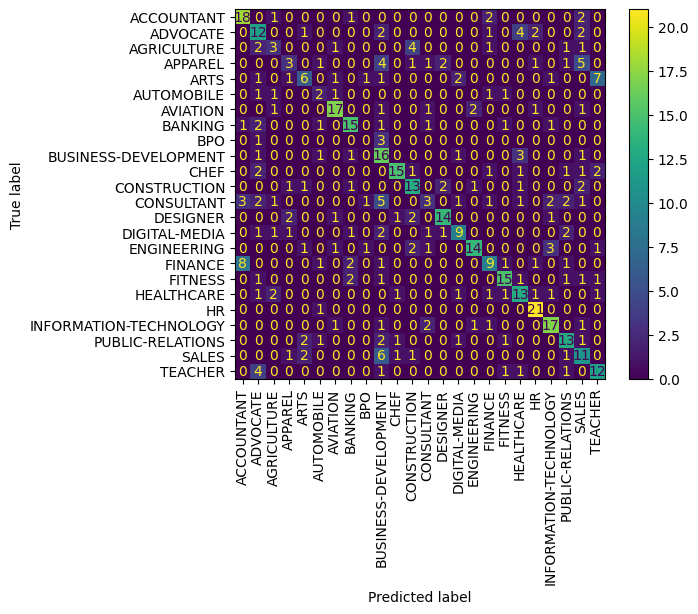

In [26]:
plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction)
plt.xticks(rotation=90)
plt.show()

In [27]:
scores = cross_val_score(SVC_Model_best, X_train_resampled, y_train_resampled, cv=skf, scoring='f1_macro')
print("F1 Macro Score (CV):", scores)

F1 Macro Score (CV): [0.54911815 0.57267251 0.57879423 0.59238536 0.5342735 ]
